In [130]:
import logging
import pathlib
import os

import pandas as pd
import seaborn
import pydub
from tqdm.notebook import tqdm
from google.cloud import storage
from google.cloud import speech


tqdm.pandas()
logger = logging.getLogger(__name__)

# Convert original file to flac

In [82]:
lines = pd.read_csv("../data/original_files.csv")
lines

,original_audio
0,/hd4tb/archivio_barbero/7_La_Prima_Guerra_Mond...
1,/hd4tb/archivio_barbero/8_Come_scoppiano_le_gu...
2,/hd4tb/archivio_barbero/9_La_Guerra_delle_Falk...


In [176]:
def convert(row):
    input_file = pathlib.Path(row["original_audio"])
    folder = input_file.parent
    name = input_file.stem
    flac = folder / "flac" / f"{name}.flac"
    sound = pydub.AudioSegment.from_mp3(input_file)
    sound = sound.set_channels(1)  # save to mono
    sound = pydub.effects.normalize(sound)
    
    sound.export(flac, format="flac")
    logger.debug("converted %s to %s", input_file, flac)
    return flac

In [177]:
lines["flac"] = lines.progress_apply(convert, axis=1)

  0%|          | 0/3 [00:00<?, ?it/s]

# Split flac file into chunks

In [178]:
def split_on_silence(row, min_silence_len, silence_thresh):
    input_file = row["flac"]
    sound = pydub.AudioSegment.from_file(input_file, format="flac")
    chunks = pydub.silence.split_on_silence(
        sound,
        min_silence_len=min_silence_len,
        silence_thresh=silence_thresh,
        keep_silence=True,
    )
    durations = pd.DataFrame(
        {
            "chunk": chunks,
            "duration": [chunk.duration_seconds for chunk in chunks],
        }
    )
    durations["flac"] = input_file
    return durations

In [187]:
chunks = lines.progress_apply(split_on_silence, axis=1, min_silence_len=1400, silence_thresh=-29)

  0%|          | 0/3 [00:00<?, ?it/s]

In [188]:
single_chunks = pd.concat(chunks.tolist()).reset_index()

<AxesSubplot: ylabel='duration'>

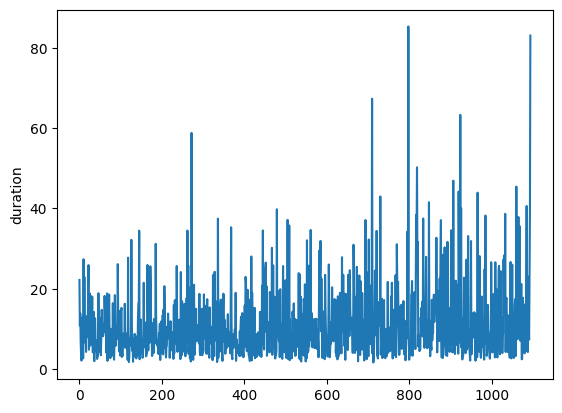

In [189]:
seaborn.lineplot(x=single_chunks.index, y=single_chunks.duration)

<AxesSubplot: xlabel='duration', ylabel='Count'>

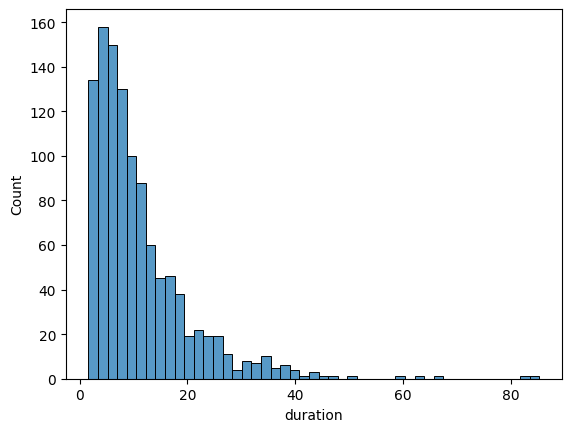

In [191]:
seaborn.histplot(single_chunks.duration)

In [106]:
def save_chunk(row):
    original_audio = pathlib.Path(row["flac"])
    folder = original_audio.parent.parent / "splits" / original_audio.stem
    folder.mkdir(exist_ok=True, parents=True)
    output_name = folder / f"{row['index']:03}.flac"
    row["chunk"].export(output_name, format="flac")
    return output_name

In [108]:
single_chunks["path"] = single_chunks.progress_apply(save_chunk, axis=1)

  0%|          | 0/1052 [00:00<?, ?it/s]

In [197]:
single_chunks["flac"].value_counts()

/hd4tb/archivio_barbero/flac/7_La_Prima_Guerra_Mondiale__Come_scoppiano_le_guerre__Barbero_Riserva_Festival_della_Mente_2014.flac      455
/hd4tb/archivio_barbero/flac/8_Come_scoppiano_le_guerre_La_seconda_guerra_mondiale_2014_2.flac                                         358
/hd4tb/archivio_barbero/flac/9_La_Guerra_delle_Falkland_-_Come_scoppiano_le_guerre_-_Barbero_Riserva_Festival_della_Mente_2014.flac    282
Name: flac, dtype: int64

In [213]:
single_chunks2 = single_chunks[single_chunks["flac"].apply(str).str.contains("seconda")]

In [216]:
single_chunks2["path"] = single_chunks2.progress_apply(save_chunk, axis=1)

  0%|          | 0/358 [00:00<?, ?it/s]

/tmp/ipykernel_345412/1894591772.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  single_chunks2["path"] = single_chunks2.progress_apply(save_chunk, axis=1)


In [217]:
single_chunks2

,index,chunk,duration,flac,path
455,0,(((<pydub.audio_segment.AudioSegment object at...,3.283991,/hd4tb/archivio_barbero/flac/8_Come_scoppiano_...,/hd4tb/archivio_barbero/splits/8_Come_scoppian...
456,1,(((<pydub.audio_segment.AudioSegment object at...,11.823991,/hd4tb/archivio_barbero/flac/8_Come_scoppiano_...,/hd4tb/archivio_barbero/splits/8_Come_scoppian...
457,2,(((<pydub.audio_segment.AudioSegment object at...,5.727007,/hd4tb/archivio_barbero/flac/8_Come_scoppiano_...,/hd4tb/archivio_barbero/splits/8_Come_scoppian...
458,3,(((<pydub.audio_segment.AudioSegment object at...,10.701995,/hd4tb/archivio_barbero/flac/8_Come_scoppiano_...,/hd4tb/archivio_barbero/splits/8_Come_scoppian...
459,4,(((<pydub.audio_segment.AudioSegment object at...,4.718005,/hd4tb/archivio_barbero/flac/8_Come_scoppiano_...,/hd4tb/archivio_barbero/splits/8_Come_scoppian...
...,...,...,...,...,...
808,353,(((<pydub.audio_segment.AudioSegment object at...,3.280998,/hd4tb/archivio_barbero/flac/8_Come_scoppiano_...,/hd4tb/archivio_barbero/splits/8_Come_scoppian...
809,354,(((<pydub.audio_segment.AudioSegment object at...,7.345986,/hd4tb/archivio_barbero/flac/8_Come_scoppiano_...,/hd4tb/archivio_barbero/splits/8_Come_scoppian...
810,355,(((<pydub.audio_segment.AudioSegment object at...,6.029002,/hd4tb/archivio_barbero/flac/8_Come_scoppiano_...,/hd4tb/archivio_barbero/splits/8_Come_scoppian...
811,356,(((<pydub.audio_segment.AudioSegment object at...,16.426009,/hd4tb/archivio_barbero/flac/8_Come_scoppiano_...,/hd4tb/archivio_barbero/splits/8_Come_scoppian...


# Upload Files to GCS

In [117]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "../secrets/barbero-translations-0ea9c0d3c73f.json"
client = storage.Client()
bucket = client.bucket("barbero-translations")

In [125]:
def upload(row, bucket):
    blob_name = f"splits/{pathlib.Path(row['flac']).stem}/{pathlib.Path(row['path']).name}"
    blob = bucket.blob(blob_name)
    blob.upload_from_filename(row["path"])
    return f"gs://{bucket.name}/{blob_name}"

In [139]:
single_chunks["gcs_uri"] = single_chunks.progress_apply(upload, axis=1, bucket=bucket)

  0%|          | 0/1052 [00:00<?, ?it/s]

In [218]:
single_chunks2["gcs_uri"] = single_chunks2.progress_apply(upload, axis=1, bucket=bucket)

  0%|          | 0/358 [00:00<?, ?it/s]

/tmp/ipykernel_345412/2522994002.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  single_chunks2["gcs_uri"] = single_chunks2.progress_apply(upload, axis=1, bucket=bucket)


# Speech to Text

In [131]:
speech_client = speech.SpeechClient()

In [141]:
def speech_to_text(row, client):
    audio = speech.RecognitionAudio(uri=row["gcs_uri"])
    transcription_gcs_uri = row["gcs_uri"].replace("splits", "transcripts").replace(".flac", ".json")
    config = speech.RecognitionConfig(
        language_code="it-IT",
        profanity_filter=False,
        enable_automatic_punctuation=True,
        model="latest_short",
    )
    output_config = speech.TranscriptOutputConfig(
        gcs_uri=transcription_gcs_uri,
    )
    request = speech.LongRunningRecognizeRequest(config=config, audio=audio, output_config=output_config)
    operation = client.long_running_recognize(request=request)
    response = operation.result()
    row["transcription_gcs_uri"] = transcription_gcs_uri
    row["response"] = response
    return row

In [142]:
transcribed = single_chunks.progress_apply(speech_to_text, axis=1, client=speech_client)

  0%|          | 0/1052 [00:00<?, ?it/s]

In [219]:
transcribed2 = single_chunks2.progress_apply(speech_to_text, axis=1, client=speech_client)

  0%|          | 0/358 [00:00<?, ?it/s]

In [144]:
transcribed.head(1).transpose()

,0
index,0
chunk,(((<pydub.audio_segment.AudioSegment object at...
duration,22.165986
flac,/hd4tb/archivio_barbero/flac/7_La_Prima_Guerra...
path,/hd4tb/archivio_barbero/splits/7_La_Prima_Guer...
gcs_uri,gs://barbero-translations/splits/7_La_Prima_Gu...
transcription_gcs_uri,gs://barbero-translations/transcripts/7_La_Pri...
response,"results {\n alternatives {\n transcript: ""..."


In [222]:
transcribed = pd.concat((transcribed[~transcribed["flac"].apply(str).str.contains("seconda")], transcribed2)).sort_values(["flac", "index"]).reset_index(drop=True)

# Extract the speech to text results

In [160]:
def extract_result(row):
    row["transcription"] = " ".join(x.alternatives[0].transcript for x in row["response"].results)
    row["billed_time"] = row["response"].total_billed_time
    return row

In [223]:
extracted = transcribed.progress_apply(extract_result, axis=1)

  0%|          | 0/901 [00:00<?, ?it/s]

In [224]:
extracted[["transcription", "billed_time", "duration"]]

,transcription,billed_time,duration
0,Buongiorno buonasera Bentornata. E bentornati ...,0 days 00:00:30,22.165986
1,Oggi ascoltiamo un episodio Barbero riserva un...,0 days 00:00:30,24.799002
2,"Scoppiano le guerre qualche mese fa, quando ab...",0 days 00:00:15,7.280000
3,C'era già un po' il clima che in fondo c'è anc...,0 days 00:00:15,5.009002
4,Notizie dall'ucraina c'era una notizia dall'ir...,0 days 00:00:15,10.540000
...,...,...,...
896,Quel deputato Enoch Powell che era intervenuto...,0 days 00:00:45,45.026984
897,E poche settimane dopo in un discorso ufficial...,0 days 00:00:15,7.390000
898,Quello che mi ha elettrizzato davvero dopo ave...,0 days 00:00:45,38.103016
899,"Ecco forse sarebbe stata più sincera, se avess...",0 days 00:00:45,30.986984


Total billed transcription time:

In [163]:
extracted["billed_time"].sum()

Timedelta('0 days 05:48:15')

Total audio time:

In [164]:
pd.to_timedelta(extracted["duration"].sum(), unit="s")

Timedelta('0 days 03:22:23.876961451')

# Manually clean the transcription

In [225]:
extracted["edited_transcription"] = extracted["transcription"]
extracted["barbero"] = 1
extracted[["barbero", "edited_transcription", "path"]].to_csv("../data/extracted2.csv")

In [233]:
cleaned = pd.read_csv("../data/extracted.csv").rename(columns={"Unnamed: 0": "index"}).astype({"index": "Int64"}).sort_values("index")

In [234]:
cleaned

,index,barbero,edited_transcription,path
0,0,0,Buongiorno buonasera Bentornata. E bentornati ...,/hd4tb/archivio_barbero/splits/7_La_Prima_Guer...
1,1,0,Oggi ascoltiamo un episodio Barbero riserva un...,/hd4tb/archivio_barbero/splits/7_La_Prima_Guer...
2,2,1,"Scoppiano le guerre qualche mese fa, quando ab...",/hd4tb/archivio_barbero/splits/7_La_Prima_Guer...
3,3,1,"Zana, c'era già un po' il clima che in fondo c...",/hd4tb/archivio_barbero/splits/7_La_Prima_Guer...
4,4,1,Notizie dall'ucraina c'era una notizia dall'ir...,/hd4tb/archivio_barbero/splits/7_La_Prima_Guer...
...,...,...,...,...
538,1047,1,Quel deputato Enoch Powell che era intervenuto...,/hd4tb/archivio_barbero/splits/9_La_Guerra_del...
539,1048,1,E poche settimane dopo in un discorso ufficial...,/hd4tb/archivio_barbero/splits/9_La_Guerra_del...
540,1049,1,Quello che mi ha elettrizzata davvero dopo ave...,/hd4tb/archivio_barbero/splits/9_La_Guerra_del...
541,1050,1,"Ecco forse sarebbe stata più sincera, se avess...",/hd4tb/archivio_barbero/splits/9_La_Guerra_del...


In [244]:
extracted["path"] = extracted["path"].apply(str)
merged = pd.merge(
    extracted.drop(columns=["edited_transcription", "barbero", "index"]),
    cleaned,
    on=["path"],
    how="left",
)

In [245]:
merged

,chunk,duration,flac,path,gcs_uri,transcription_gcs_uri,response,transcription,billed_time,index,barbero,edited_transcription
0,(((<pydub.audio_segment.AudioSegment object at...,22.165986,/hd4tb/archivio_barbero/flac/7_La_Prima_Guerra...,/hd4tb/archivio_barbero/splits/7_La_Prima_Guer...,gs://barbero-translations/splits/7_La_Prima_Gu...,gs://barbero-translations/transcripts/7_La_Pri...,"results {\n alternatives {\n transcript: ""...",Buongiorno buonasera Bentornata. E bentornati ...,0 days 00:00:30,0,0,Buongiorno buonasera Bentornata. E bentornati ...
1,(((<pydub.audio_segment.AudioSegment object at...,24.799002,/hd4tb/archivio_barbero/flac/7_La_Prima_Guerra...,/hd4tb/archivio_barbero/splits/7_La_Prima_Guer...,gs://barbero-translations/splits/7_La_Prima_Gu...,gs://barbero-translations/transcripts/7_La_Pri...,"results {\n alternatives {\n transcript: ""...",Oggi ascoltiamo un episodio Barbero riserva un...,0 days 00:00:30,1,0,Oggi ascoltiamo un episodio Barbero riserva un...
2,(((<pydub.audio_segment.AudioSegment object at...,7.280000,/hd4tb/archivio_barbero/flac/7_La_Prima_Guerra...,/hd4tb/archivio_barbero/splits/7_La_Prima_Guer...,gs://barbero-translations/splits/7_La_Prima_Gu...,gs://barbero-translations/transcripts/7_La_Pri...,"results {\n alternatives {\n transcript: ""...","Scoppiano le guerre qualche mese fa, quando ab...",0 days 00:00:15,2,1,"Scoppiano le guerre qualche mese fa, quando ab..."
3,(((<pydub.audio_segment.AudioSegment object at...,5.009002,/hd4tb/archivio_barbero/flac/7_La_Prima_Guerra...,/hd4tb/archivio_barbero/splits/7_La_Prima_Guer...,gs://barbero-translations/splits/7_La_Prima_Gu...,gs://barbero-translations/transcripts/7_La_Pri...,"results {\n alternatives {\n transcript: ""...",C'era già un po' il clima che in fondo c'è anc...,0 days 00:00:15,3,1,"Zana, c'era già un po' il clima che in fondo c..."
4,(((<pydub.audio_segment.AudioSegment object at...,10.540000,/hd4tb/archivio_barbero/flac/7_La_Prima_Guerra...,/hd4tb/archivio_barbero/splits/7_La_Prima_Guer...,gs://barbero-translations/splits/7_La_Prima_Gu...,gs://barbero-translations/transcripts/7_La_Pri...,"results {\n alternatives {\n transcript: ""...",Notizie dall'ucraina c'era una notizia dall'ir...,0 days 00:00:15,4,1,Notizie dall'ucraina c'era una notizia dall'ir...
...,...,...,...,...,...,...,...,...,...,...,...,...
896,(((<pydub.audio_segment.AudioSegment object at...,45.026984,/hd4tb/archivio_barbero/flac/9_La_Guerra_delle...,/hd4tb/archivio_barbero/splits/9_La_Guerra_del...,gs://barbero-translations/splits/9_La_Guerra_d...,gs://barbero-translations/transcripts/9_La_Gue...,"results {\n alternatives {\n transcript: ""...",Quel deputato Enoch Powell che era intervenuto...,0 days 00:00:45,1047,1,Quel deputato Enoch Powell che era intervenuto...
897,(((<pydub.audio_segment.AudioSegment object at...,7.390000,/hd4tb/archivio_barbero/flac/9_La_Guerra_delle...,/hd4tb/archivio_barbero/splits/9_La_Guerra_del...,gs://barbero-translations/splits/9_La_Guerra_d...,gs://barbero-translations/transcripts/9_La_Gue...,"results {\n alternatives {\n transcript: ""...",E poche settimane dopo in un discorso ufficial...,0 days 00:00:15,1048,1,E poche settimane dopo in un discorso ufficial...
898,(((<pydub.audio_segment.AudioSegment object at...,38.103016,/hd4tb/archivio_barbero/flac/9_La_Guerra_delle...,/hd4tb/archivio_barbero/splits/9_La_Guerra_del...,gs://barbero-translations/splits/9_La_Guerra_d...,gs://barbero-translations/transcripts/9_La_Gue...,"results {\n alternatives {\n transcript: ""...",Quello che mi ha elettrizzato davvero dopo ave...,0 days 00:00:45,1049,1,Quello che mi ha elettrizzata davvero dopo ave...
899,(((<pydub.audio_segment.AudioSegment object at...,30.986984,/hd4tb/archivio_barbero/flac/9_La_Guerra_delle...,/hd4tb/archivio_barbero/splits/9_La_Guerra_del...,gs://barbero-translations/splits/9_La_Guerra_d...,gs://barbero-translations/transcripts/9_La_Gue...,"results {\n alternatives {\n transcript: ""...","Ecco forse sarebbe stata più sincera, se a

In [246]:
merged.to_pickle("../data/merged.pkl.gz")

In [298]:
def write_wavs(row):
    path = pathlib.Path(row['path'])
    folder = pathlib.Path(f"/ssd500gb/archivio_barbero/split_wav/{path.parent.name}")
    folder.mkdir(exist_ok=True, parents=True)
    output_name = f"{folder}/{path.stem}.wav"
    chunk = row["chunk"]
    chunk.set_frame_rate(16000).export(output_name, format="wav")
    return output_name

In [299]:
merged["audio_file"] = merged.progress_apply(write_wavs, axis=1)

  0%|          | 0/901 [00:00<?, ?it/s]

In [264]:
final = merged[merged["barbero"].astype(bool)][["audio_file", "edited_transcription"]].rename(columns={"edited_transcription": "text"})
final["audio_file"] = final["audio_file"].apply(lambda x: pathlib.Path(x).relative_to(pathlib.Path(x).parent.parent))

# Transcribe numbers

In [295]:
import re
from num2words import num2words


def transcribe_numbers(row):
    text = row["text"]
    numbers = re.findall("[0-9]+", text)
    if numbers:
        for number in numbers:
            transcribed = num2words(int(number), lang="it")
            text = text.replace(number, transcribed)
    return text

In [296]:
final["text"] = final.progress_apply(transcribe_numbers, axis=1)

  0%|          | 0/889 [00:00<?, ?it/s]

In [297]:
final.to_csv("../data/audio_metadata.csv", sep="|", index=False)